In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from ast import literal_eval
import statsmodels.api as sm

- [Introduction](#introduction)
- [Exploration](#exploration)
  - [Genres](#genres)
  - [Actors](#actors)
  - [Runtime](#runtime)
  - [Release Date](#release-date)
  - [Countries](#countries)
  - [Tropes](#tropes)
- [Conclusion](#conclusion)

In [71]:
def hotencode(df, column, id_column, prefix='onehot'):
    # Create a new dataframe with the one hot encoded columns
    one_hot_df = pd.get_dummies(df, columns=[column], prefix=prefix)

    # Removing symbols from column names to make the regression model work
    #for ch in ['/', ' ', "'", '-', '&', '[', ']']:
        #one_hot_df.columns = one_hot_df.columns.str.replace(ch, "")
    
    one_hot_columns = list(filter(lambda x: x.startswith(prefix), one_hot_df.columns))

    # Convert bool to int
    one_hot_df[one_hot_columns] = one_hot_df[one_hot_columns].astype(int)

    one_hot_df = one_hot_df.groupby(id_column)[one_hot_columns].sum().reset_index()
    
    return one_hot_df[[id_column] + one_hot_columns], one_hot_columns

# Introduction

In [72]:
data = pd.read_csv('data/processed/cmu_movies_augmented.csv')

In [73]:
data['imdb_rating_scaled'] = data['imdb_rating'] * 10
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']
data['rating_ratio'] = data['imdb_rating_scaled'] / data['metascore']

print(f'Total movies: {len(data)}')
data.dropna(subset=['rating_difference'], inplace=True)
print(f'Total movies with rating_difference: {len(data)}')

Total movies: 8529
Total movies with rating_difference: 7770


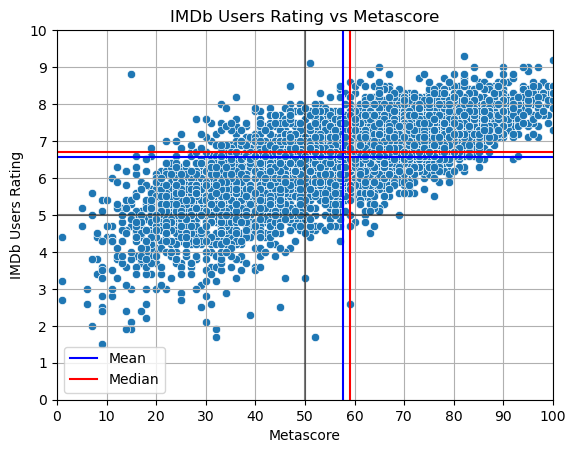

In [74]:
sns.scatterplot(x="metascore", y="imdb_rating", data=data)
plt.title("IMDb Users Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

# plot center lines
plt.axhline(y=5, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=50, color='k', linestyle='-', alpha=0.5)

# plot mean lines
plt.axhline(y=data['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=data['metascore'].mean(), color='b', linestyle='-')

# plot median lines
plt.axhline(y=data['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=data['metascore'].median(), color='r', linestyle='-')

# legend the lines but not the scatter plots
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
plt.legend(handles=[blue_line, red_line])

plt.show()

Interestingly, we can see that the ratings and the metascore don't seem to have the same average. Plotting their respective mean and median allows to see that metascore mean is lower than the users mean. Does that mean that the users and the critics don't like the same type of movies ? Or simply that the users are more generous than the critics ? Let's see if we can find some answers diving deeper into the data.

The first step is to find a common metric that allows to directly compare the features to the ratings. We'll define the **rating difference** as the difference between the rating of the users and the metascore. We'll also define the **rating ratio** as the ratio between the rating of the users and the metascore. We'll use these two metrics to compare the ratings of the users and the critics.

In [75]:
# define the rating difference
data['imdb_rating_scaled'] = data['imdb_rating'] * 10 # rescale imbd rating to 0-100
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']

# define the rating ratio
data['rating_ratio'] = data['metascore'] / data['imdb_rating_scaled']

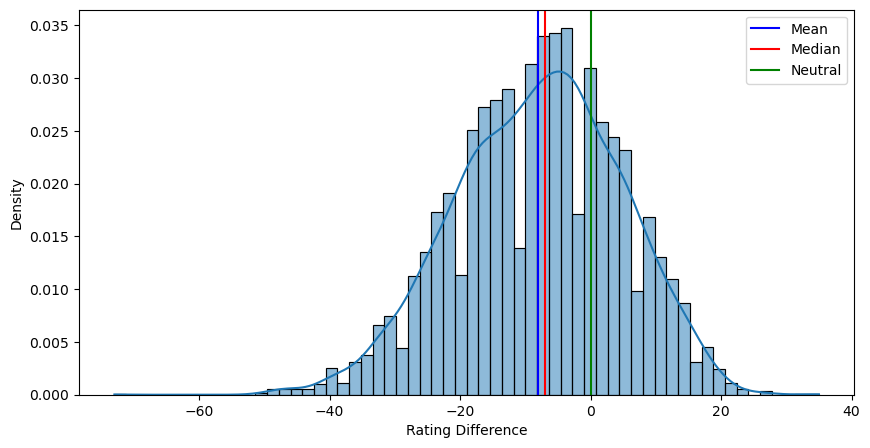

In [76]:
# Plot the mean and median and neutral rating difference
plt.figure(figsize=(10,5))
sns.histplot(data['rating_difference'], kde=True, stat='density', alpha=0.5)
plt.axvline(data['rating_difference'].mean(), color='b')
plt.axvline(data['rating_difference'].median(), color='r')
plt.axvline(0, color='g')
plt.xlabel('Rating Difference')
plt.ylabel('Density')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

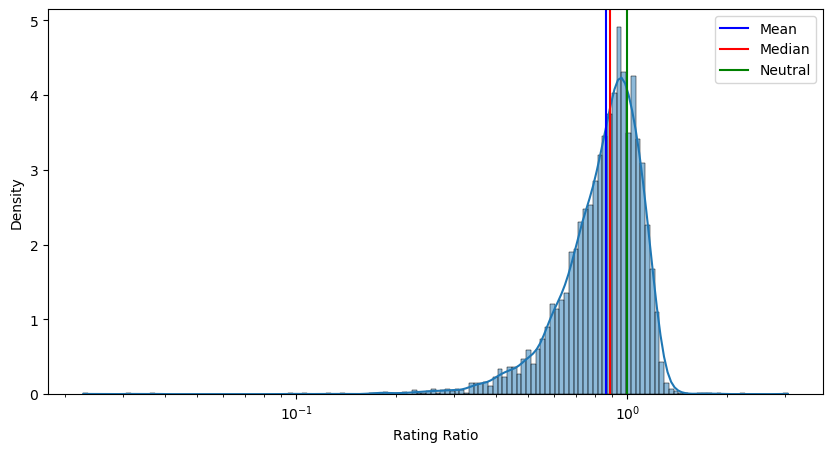

In [77]:
# Plot the mean and median and neutral rating ratio
plt.figure(figsize=(10,5))
sns.histplot(data['rating_ratio'], kde=True, stat='density', alpha=0.5, log_scale=True)
plt.axvline(data['rating_ratio'].mean(), color='b')
plt.axvline(data['rating_ratio'].median(), color='r')
plt.axvline(1, color='g')
plt.xlabel('Rating Ratio')
plt.ylabel('Density')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

In [78]:
# perform t-test to see if the mean between users and critics are different
# t-test for rating difference
print("The imbd_rating and the metascore means are statistically different (pvalue: {}).".format(stats.ttest_ind(data['imdb_rating_scaled'], data['metascore'], nan_policy='omit').pvalue))

# test if distributions are gaussian
print("The rating difference is normally distributed (pvalue: {}).".format(stats.normaltest(data['rating_difference'], nan_policy='omit').pvalue))
print("The rating ratio is normally distributed (pvalue: {}).".format(stats.normaltest(data['rating_ratio'], nan_policy='omit').pvalue))
print("The imbd_rating is normally distributed (pvalue: {}).".format(stats.normaltest(data['imdb_rating_scaled'], nan_policy='omit').pvalue))
print("The metascore is normally distributed (pvalue: {}).".format(stats.normaltest(data['metascore'], nan_policy='omit').pvalue))


The imbd_rating and the metascore means are statistically different (pvalue: 8.92450543214832e-250).
The rating difference is normally distributed (pvalue: 2.96874250693388e-15).
The rating ratio is normally distributed (pvalue: 4.979113236740761e-87).
The imbd_rating is normally distributed (pvalue: 2.6344986648482076e-190).
The metascore is normally distributed (pvalue: 1.9816398628762922e-33).


Performing a formal statistical test battery allows to see that indeed:
- The users and the critics don't have the same average ratings
- The distributions of the ratings (and the derived metrics for ratio and difference) are normal

These tests allows to reinforce what the visual inspection of the graphs suggested.

And now, how can we explain the differences between the ratings of the users and the critics ? Let's try to see if the genres of the movies have an impact on the ratings.

# Exploration

## Genres

In [79]:
# Function to parse the genres column
def parse_genres(genres_str):
    try:
        genres_dict = literal_eval(genres_str)
        return list(genres_dict.values())
    except:
        return []

# Apply the function to the genres column
df_genres = data.copy()

df_genres['parsed_genres'] = data['genres'].apply(parse_genres)

# Explode the dataset so each genre gets its own row
df_genres = df_genres.explode('parsed_genres')

# Group by genre and calculate average rating_difference for each genre
genre_scores = df_genres.groupby('parsed_genres')['rating_difference'].mean().reset_index()

# Dropping rows where genre is NaN or Metascore is NaN
genre_scores = genre_scores.dropna()

# Sorting the genres by average rating_difference
genre_scores_sorted = genre_scores.sort_values(by='rating_difference', ascending=False)

# Display the top 10 genres
top_genres = genre_scores_sorted.head(10)
display(top_genres)

# Display the bottom 10 genres
flop_genres = genre_scores_sorted.tail(10)
display(flop_genres)

,parsed_genres,rating_difference
140,Foreign legion,18.000000
281,Star vehicle,16.000000
226,Point of view shot,16.000000
53,Cavalry Film,15.000000
47,British New Wave,15.000000
105,Ealing Comedies,15.000000
267,Silent film,14.545455
237,Propaganda film,9.333333
186,Kitchen sink realism,9.000000
40,Black-and-white,7.275862


,parsed_genres,rating_difference
293,Sword and sorcery,-18.538462
174,Indian Western,-18.666667
292,Sword and Sandal,-19.500000
176,Inspirational Drama,-19.733333
153,Gross-out film,-20.682927
152,Gross out,-20.682927
26,Archaeology,-21.000000
192,Live action,-25.500000
306,Werewolf fiction,-28.000000
217,Ninja movie,-29.000000


### Pearson Correlation

In [80]:
one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'parsed_genres', id_column='freebase_id', prefix='onehot-genre')

# Add the rating_difference column to the one hot encoded dataframe
one_hot_movies_genres_merged = one_hot_movies_genres.merge(data[['freebase_id', 'rating_difference']], on='freebase_id')

# Dictionary to store results
correlation_results = {}

# Calculate correlation and p-value for each genre
for col in one_hot_movies_genres_columns:
    correlation, p_value = pearsonr(one_hot_movies_genres_merged[col], one_hot_movies_genres_merged['rating_difference'])
    if not np.isnan(correlation):
        correlation_results[col] = {'correlation': correlation, 'p_value': p_value}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(correlation_results, orient='index').sort_values(by='correlation', ascending=False)
display(results_df.head(10))
display(results_df.tail(10))


,correlation,p_value
onehot-genre_World cinema,0.172514,5.686407e-53
onehot-genre_Drama,0.169811,2.343363e-51
onehot-genre_Black-and-white,0.166375,2.420414e-49
onehot-genre_Art film,0.094680,6.102339e-17
onehot-genre_Documentary,0.077321,8.804232e-12
onehot-genre_Film noir,0.076741,1.257547e-11
onehot-genre_New Hollywood,0.073733,7.654204e-11
onehot-genre_Biography,0.070240,5.712804e-10
onehot-genre_Silent film,0.066990,3.405795e-09
onehot-genre_History,0.064335,1.379554e-08


,correlation,p_value
onehot-genre_Gross out,-0.072547,1.530600e-10
onehot-genre_Gross-out film,-0.072547,1.530600e-10
onehot-genre_Horror,-0.082430,3.407698e-13
onehot-genre_Slasher,-0.083825,1.353157e-13
onehot-genre_Teen,-0.088492,5.519274e-15
onehot-genre_Comedy,-0.088898,4.146261e-15
onehot-genre_Thriller,-0.089570,2.573478e-15
onehot-genre_Slapstick,-0.097525,6.945748e-18
onehot-genre_Action/Adventure,-0.114463,4.444883e-24
onehot-genre_Action,-0.141135,7.339506e-36


### OLS

In [81]:
X = one_hot_movies_genres_merged[one_hot_movies_genres_columns]
y = one_hot_movies_genres_merged['rating_difference']

X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5.641
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          2.23e-174
Time:                        21:23:14   Log-Likelihood:                -29944.
No. Observations:                7770   AIC:                         6.052e+04
Df Residuals:                    7456   BIC:                         6.270e+04
Df Model:                         313                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [82]:
# Find the genres with p-values less than 0.05
significant_genres = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        genre = row[0].split('_')[1]
        colname = row[0]
        significant_genres.append([colname, genre, float(row[1]), float(row[4])])

# Convert the list of significant genres to a DataFrame
significant_genres_df = pd.DataFrame(significant_genres, columns=['colname', 'genre', 'coef', 'p_value'])
significant_genres_df = significant_genres_df.sort_values(by='coef', ascending=False)
display(significant_genres_df.head(10))
display(significant_genres_df.tail(10))

,colname,genre,coef,p_value
47,onehot-genre_Point of view shot,Point of view shot,26.7613,0.036
21,onehot-genre_Ealing Comedies,Ealing Comedies,26.2156,0.025
10,onehot-genre_Cavalry Film,Cavalry Film,24.1035,0.040
30,onehot-genre_Gay Interest,Gay Interest,18.7657,0.025
31,onehot-genre_Giallo,Giallo,18.2464,0.008
43,onehot-genre_Mumblecore,Mumblecore,14.4498,0.000
24,onehot-genre_Experimental film,Experimental film,12.8642,0.004
16,onehot-genre_Coming-of-age film,Coming-of-age film,12.5009,0.034
7,onehot-genre_Black-and-white,Black-and-white,11.7451,0.000
54,onehot-genre_Silent film,Silent film,10.4556,0.005


,colname,genre,coef,p_value
11,onehot-genre_Childhood Drama,Childhood Drama,-6.8956,0.000
26,onehot-genre_Fantasy Drama,Fantasy Drama,-7.9493,0.047
8,onehot-genre_Bollywood,Bollywood,-9.7202,0.000
60,onehot-genre_Sword and sorcery,Sword and sorcery,-9.7311,0.022
5,onehot-genre_Avant-garde,Avant-garde,-12.1595,0.013
39,onehot-genre_Inspirational Drama,Inspirational Drama,-12.7453,0.000
0,onehot-genre_Acid western,Acid western,-17.5629,0.013
40,onehot-genre_Live action,Live action,-18.9189,0.024
29,onehot-genre_Gay,Gay,-19.5572,0.020
37,onehot-genre_Indian Western,Indian Western,-28.4458,0.000


In [83]:
significant_genres_columns = significant_genres_df['colname'].tolist()

## Actors

In [84]:
characters_data = pd.read_csv('data/preprocessed/character.metadata.preprocessed.tsv', sep='\t')

In [85]:
# Filter out movies that are not in the movies dataset
characters_data = characters_data[characters_data['wikipedia_id'].isin(data['wikipedia_id'])]

In [86]:
print(f'Unique actors: {len(characters_data["freebase_actor_id"].unique())}')

Unique actors: 22416


In [87]:
# Keep actors that have at least 10 movies
actor_counts = characters_data['freebase_actor_id'].value_counts()
actors_to_keep = actor_counts[actor_counts >= 10].index
characters_data = characters_data[characters_data['freebase_actor_id'].isin(actors_to_keep)]

In [88]:
print(f'Unique actors with >=10 movies: {len(characters_data["freebase_actor_id"].unique())}')

Unique actors with >=10 movies: 1618


In [89]:
# Hot encode the actor freebase id column 
one_hot_actors, one_hot_actors_columns = hotencode(characters_data, 'freebase_actor_id', id_column='wikipedia_id', prefix='onehot-actor')

In [90]:
one_hot_actors_merged = one_hot_actors.merge(data[['wikipedia_id', 'rating_difference']], on='wikipedia_id')

In [91]:
X = one_hot_actors_merged[one_hot_actors_columns]
y = one_hot_actors_merged['rating_difference']

X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     1.552
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.19e-27
Time:                        21:23:25   Log-Likelihood:                -20634.
No. Observations:                5582   AIC:                         4.451e+04
Df Residuals:                    3963   BIC:                         5.524e+04
Df Model:                        1618                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [92]:
# Print the highest and lowest coefficients sorted
significant_actors = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        actor_id = row[0].split('_')[1]
        colname = row[0]
        significant_actors.append([colname, actor_id, float(row[1]), float(row[4])])

# Convert the list of significant actors to a DataFrame
significant_actors_df = pd.DataFrame(significant_actors, columns=['colname', 'freebase_actor_id', 'coef', 'p_value'])

significant_actors_df = pd.merge(significant_actors_df, characters_data[['freebase_actor_id', 'actor_name']].drop_duplicates(), left_on='freebase_actor_id', right_on='freebase_actor_id', how='left')

significant_actors_df = significant_actors_df.sort_values(by='coef', ascending=False)

# Merge with the characters dataset to get the actor names

display(significant_actors_df.head(20))
display(significant_actors_df.tail(20))

,colname,freebase_actor_id,coef,p_value,actor_name
72,onehot-actor_/m/04__f,/m/04,16.3939,0.000,NaN
86,onehot-actor_/m/06hhrs,/m/06hhrs,14.4668,0.001,Richard Kind
125,onehot-actor_/m/0p8r1,/m/0p8r1,14.2618,0.000,John Ratzenberger
84,onehot-actor_/m/0668qk,/m/0668qk,13.2798,0.001,Olivier Gourmet
38,onehot-actor_/m/02hfsd,/m/02hfsd,12.8353,0.001,Ward Bond
27,onehot-actor_/m/021t8p,/m/021t8p,11.8862,0.002,Michel Piccoli
112,onehot-actor_/m/0cbkc,/m/0cbkc,11.7755,0.000,Catherine Deneuve
74,onehot-actor_/m/04sry,/m/04sry,11.7384,0.002,Martin Scorsese
64,onehot-actor_/m/04264n,/m/04264n,11.6829,0.002,Keenan Wynn
17,onehot-actor_/m/01mvth,/m/01mvth,11.4419,0.048,Jerry Nelson


,colname,freebase_actor_id,coef,p_value,actor_name
119,onehot-actor_/m/0dwz5n,/m/0dwz5n,-9.4871,0.024,Frank Grillo
115,onehot-actor_/m/0czv3f,/m/0czv3f,-9.4916,0.018,Oscar Isaac
60,onehot-actor_/m/03s2dj,/m/03s2dj,-9.5406,0.008,Callum Keith Rennie
78,onehot-actor_/m/04z542,/m/04z542,-9.5807,0.011,Michael Lerner
50,onehot-actor_/m/03811k,/m/03811k,-9.5867,0.016,Bridget Moynahan
83,onehot-actor_/m/05qh0j,/m/05qh0j,-9.6456,0.035,Kevin Heffernan
42,onehot-actor_/m/02nrdp,/m/02nrdp,-9.6666,0.021,Dom DeLuise
96,onehot-actor_/m/07vljr,/m/07vljr,-10.1628,0.027,Allen Garfield
88,onehot-actor_/m/06rq2l,/m/06rq2l,-10.3349,0.039,Allen Covert
108,onehot-actor_/m/0bs6hr,/m/0bs6hr,-10.5511,0.007,Norman Reedus


In [93]:
# List movies of an actor
def list_movies_of_actor(actor_id):
    movies_ids = characters_data[characters_data['freebase_actor_id'] == actor_id]['wikipedia_id'].unique()
    display(characters_data[characters_data['freebase_actor_id'] == actor_id]['actor_name'].unique())
    return data[data['wikipedia_id'].isin(movies_ids)]

In [94]:
significant_actors_columns = significant_actors_df['colname'].tolist()

## Runtime

In [95]:
df_runtime = data.dropna(subset=['runtime'])

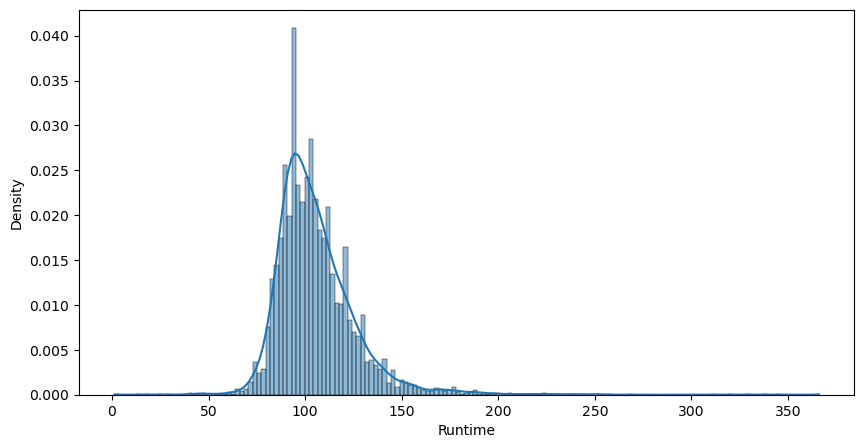

In [96]:
# Plot distribution of runtime
plt.figure(figsize=(10,5))
sns.histplot(df_runtime['runtime'], kde=True, stat='density', alpha=0.5)
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

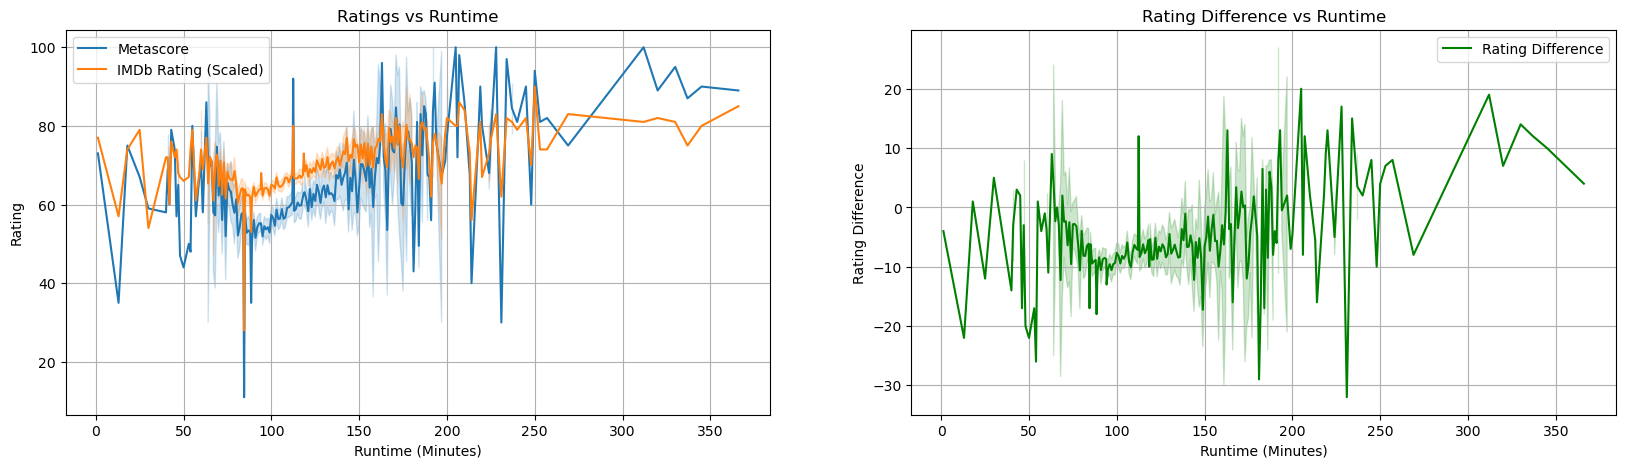

In [97]:
# Plot the distribution of rating difference per runtime
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="runtime", y="metascore", data=df_runtime, label='Metascore', ax=ax[0])
sns.lineplot(x="runtime", y="imdb_rating_scaled", data=df_runtime, label='IMDb Rating (Scaled)', ax=ax[0])

sns.lineplot(x="runtime", y="rating_difference", data=df_runtime, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Runtime")
ax[0].set_xlabel("Runtime (Minutes)")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Runtime")
ax[1].set_xlabel("Runtime (Minutes)")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

The plot shows a noisy relationship between rating difference and runtime, with no clear pattern. The data points are widely spread out, indicating a lot of variability in the rating differences for movies of similar lengths.

In [98]:
# Fit a OLS model
X = df_runtime['runtime']
y = df_runtime['rating_difference']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     45.54
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.61e-11
Time:                        21:23:37   Log-Likelihood:                -29623.
No. Observations:                7493   AIC:                         5.925e+04
Df Residuals:                    7491   BIC:                         5.926e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7768      0.740    -17.271      0.0

- The R-squared value is 0.006, which means that only 0.6% of the variance in the rating difference is explained by the runtime. This indicates a very weak linear relationship between runtime and rating difference.
  
- The constant (intercept) coefficient is -12.7768 with a p-value close to 0, suggesting that the intercept is significantly different from 0. However, given that runtime cannot be 0, the practical interpretation of the intercept is limited.
  
- The runtime coefficient is 0.0463, indicating that for every additional minute of runtime, the rating difference increases by 0.0463 on average. While this is statistically significant (p-value < 0.001), the effect size is very small.

## Release date

In [99]:
df_release_date = data.copy()
df_release_date['release_date_datetime'] = pd.to_datetime(df_release_date['release_date_datetime'])
df_release_date['year'] = df_release_date['release_date_datetime'].dt.year
df_release_date['month'] = df_release_date['release_date_datetime'].dt.month

df_release_date = df_release_date.dropna(subset=['year', 'month'])
print(f'Movies with a release date and month: {len(df_release_date)}/{len(data)}')

Movies with a release date and month: 7702/7770


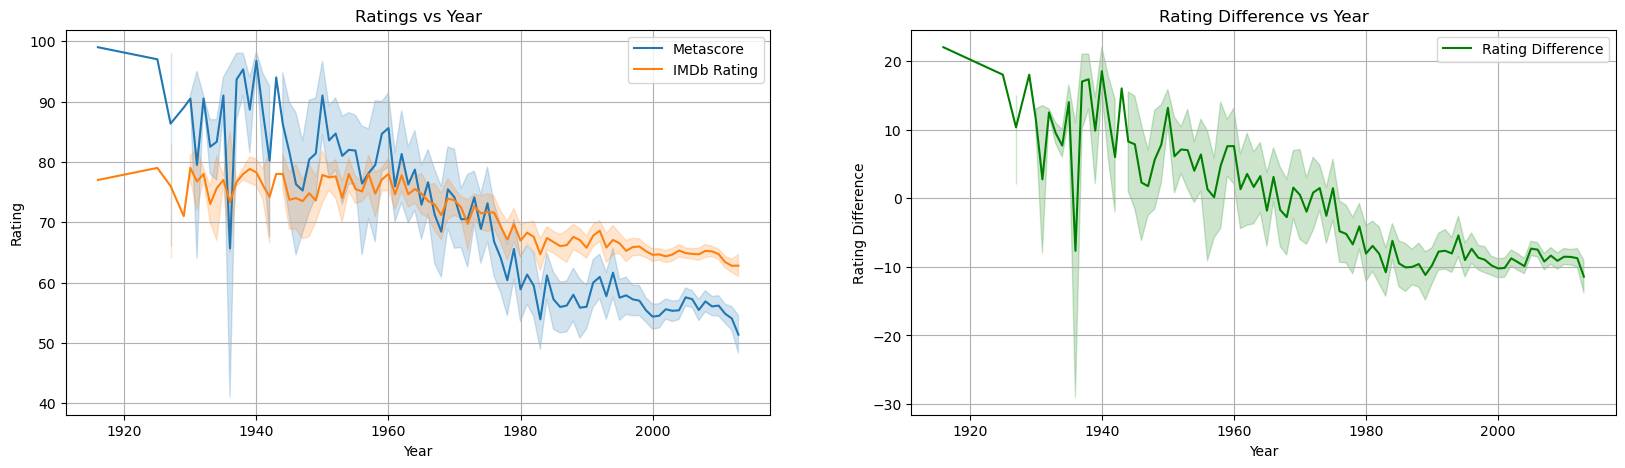

In [100]:
# Plot the distribution of rating difference per year
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="year", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="year", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="year", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Year")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The first set of plots shows that both the Metascore and IMDb rating have a general downward trend over the years. This could suggest that either movies are getting worse, or perhaps more likely, that scoring criteria have become stricter over time.

- The plot for rating differences over the years indicates that the gap between Metascore and IMDb ratings has generally been widening. Early in the data, Metascore ratings are higher than IMDb, and over time, this trend reverses.

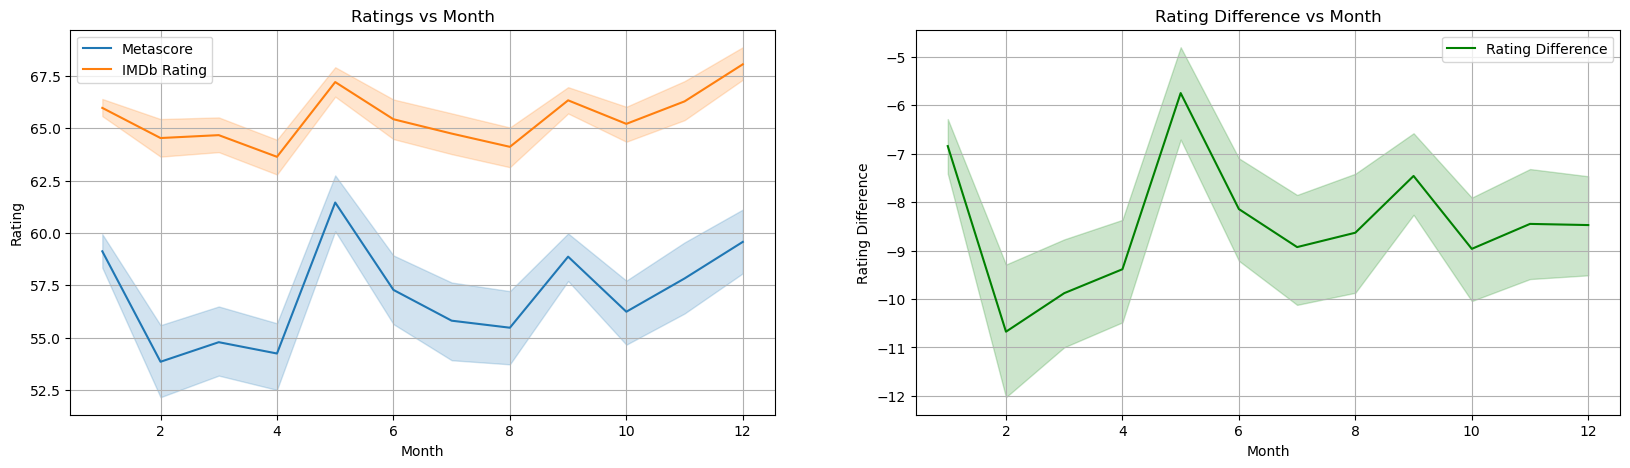

In [101]:
# Plot the distribution of rating difference per month
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="month", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="month", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="month", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The monthly plots indicate some seasonality in ratings, with certain months having higher or lower average ratings. This could be due to the type of movies typically released in those months (e.g., Oscar-bait films in December).

- The monthly rating difference plot shows that the discrepancy between the two rating sources also varies by month, with some months showing a larger gap than others.

In [102]:
# Fit a linear regression model
X = df_release_date[['year', 'month']]
y = df_release_date['rating_difference']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     166.5
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.65e-71
Time:                        21:23:45   Log-Likelihood:                -30330.
No. Observations:                7702   AIC:                         6.067e+04
Df Residuals:                    7699   BIC:                         6.069e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.4519     21.250     17.762      0.0

- The model suggests that both year and month are significant predictors of the rating difference.

- The coefficient for year is -0.1925, indicating that with each passing year, the rating difference decreases by 0.1925 points. Given the R-squared value of 0.041, we know that year and month together explain about 4.1% of the variance in rating difference, which is not a lot, but it is significant.

- The coefficient for month is -0.0953, suggesting a smaller but still significant monthly effect on rating differences.

## Countries

In [103]:
# Parse the countries column
def parse_countries(countries_str):
    try:
        countries_dict = literal_eval(countries_str)
        return list(countries_dict.values())
    except:
        return None

df_countries = data.copy()

# Apply the function to the countries column
df_countries['parsed_countries'] = df_countries['countries'].apply(parse_countries)

df_countries = df_countries.dropna(subset=['countries'])

print(f'Movies with countries: {len(df_countries)}/{len(data)}')

# Explode the dataset so each (country, movie) gets its own row
df_countries = df_countries.explode('parsed_countries')

# Hot encode countries per movie
one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'parsed_countries', id_column='wikipedia_id', prefix='onehot-country')

one_hot_countries_merged = one_hot_countries.merge(df_countries[['wikipedia_id', 'rating_difference']], on='wikipedia_id')

Movies with countries: 7770/7770


In [104]:
# Fit a linear regression model
X = one_hot_countries_merged[one_hot_countries_columns]
y = one_hot_countries_merged['rating_difference']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     12.19
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          6.52e-204
Time:                        21:23:46   Log-Likelihood:                -45074.
No. Observations:               11569   AIC:                         9.038e+04
Df Residuals:                   11454   BIC:                         9.122e+04
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

- The Adjusted R-squared value is 0.099, meaning that roughly 9.9% of the variance in the rating difference can be explained by the model. This is a significant improvement from previous models you mentioned, but still suggests that there are other factors not included in the model that influence the rating difference.

In [105]:
# Print the highest and lowest coefficients sorted
significant_countries = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        country = row[0].split('_')[1]
        colname = row[0]
        significant_countries.append([colname, country, float(row[1]), float(row[4])])

# Convert the list of significant countries to a DataFrame
significant_countries_df = pd.DataFrame(significant_countries, columns=['colname', 'country', 'coef', 'p_value'])
significant_countries_df = significant_countries_df.sort_values(by='coef', ascending=False)
display(significant_countries_df.head(20))
display(significant_countries_df.tail(20))

,colname,country,coef,p_value
35,onehot-country_Serbia and Montenegro,Serbia and Montenegro,29.5768,0.000
0,onehot-country_Albania,Albania,21.0608,0.001
44,onehot-country_Weimar Republic,Weimar Republic,19.7990,0.001
4,onehot-country_Bahamas,Bahamas,15.1371,0.006
28,onehot-country_Panama,Panama,13.0024,0.031
22,onehot-country_Lithuania,Lithuania,12.5008,0.006
36,onehot-country_Slovak Republic,Slovak Republic,11.9341,0.013
6,onehot-country_Cameroon,Cameroon,11.3928,0.031
21,onehot-country_Kuwait,Kuwait,10.7567,0.048
37,onehot-country_Soviet Union,Soviet Union,10.2146,0.009


,colname,country,coef,p_value
14,onehot-country_Germany,Germany,-1.9558,0.000
2,onehot-country_Argentina,Argentina,-2.2334,0.039
25,onehot-country_Netherlands,Netherlands,-2.4386,0.003
7,onehot-country_Canada,Canada,-2.5657,0.000
23,onehot-country_Luxembourg,Luxembourg,-2.7825,0.022
9,onehot-country_Czech Republic,Czech Republic,-3.7378,0.002
16,onehot-country_India,India,-3.8242,0.000
20,onehot-country_Kingdom of Great Britain,Kingdom of Great Britain,-5.4617,0.041
43,onehot-country_United States of America,United States of America,-5.7336,0.000
33,onehot-country_Romania,Romania,-6.0635,0.000


- The countries with positive coefficients (like Albania, Bahamas) suggest that movies associated with these countries tend to have a higher Metascore compared to IMDb rating.

- Conversely, countries with negative coefficients (like Denmark, Bulgaria) suggest that movies associated with these countries tend to have a lower Metascore compared to IMDb rating.

- The p_value indicates the statistical significance of these coefficients. For example, countries like Serbia and Montenegro, Albania, and the Weimar Republic have coefficients that are statistically significant (p < 0.05), meaning we can be confident that these are not due to random chance.

It's important to note that correlation does not imply causation. The coefficients must also be interpreted with caution, especially for countries with a small number of movies represented in the dataset, as the estimates may be less reliable.

In [106]:
significant_countries_columns = significant_countries_df['colname'].tolist()

## Character tropes

### Preprocessing

In [107]:
tvtropes = pd.read_csv('data/raw/tvtropes.clusters.txt', sep='\t', header=None, names=['cluster_name', 'character'])

In [108]:
import json
def extract_character(character):
    """
    Extracts character information from a dictionary.

    Parameters:
    character_dict (dict): A dictionary containing character details.

    Returns:
    tuple: A tuple with extracted character details.
    """
    character_dict = json.loads(character)
    character_name = character_dict.get("char", "Unknown")
    movie_title = character_dict.get("movie", "Unknown")
    freebase_actor_map_id = character_dict.get("id", "Unknown")
    actor_name = character_dict.get("actor", "Unknown")

    return character_name, movie_title, freebase_actor_map_id, actor_name

In [109]:
tvtropes[['character_name', 'movie_name', 'freebase_actor_map_id', 'actor_name']] = tvtropes['character'].apply(lambda x: extract_character(x)).apply(pd.Series)

In [110]:
# Add freebase_id of movie from characters_data based on freebase_actor_map_id
df_tvtropes = pd.merge(tvtropes, characters_data[['freebase_actor_map_id', 'freebase_id']], on='freebase_actor_map_id', how='left')

In [111]:
# Drop nan values
df_tvtropes.dropna(subset=['freebase_id'], inplace=True)

df_tvtropes = df_tvtropes.reset_index(drop=True)

In [112]:
print(f'Movies with tvtropes: {len(df_tvtropes["freebase_id"].unique())}/{len(data)}')

Movies with tvtropes: 246/7770


In [113]:
df_tvtropes.head()

,cluster_name,character,character_name,movie_name,freebase_actor_map_id,actor_name,freebase_id
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":...",Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,/m/04vcfx
1,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""...",Daniel Jackson,Stargate,/m/0k3rhh,James Spader,/m/070g7
2,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo...",Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,/m/04mcw4
3,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo...",Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford,/m/0f4yh
4,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo...",Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford,/m/0k_9j


### Hotencoding

In [114]:
# Hot encode the cluster_name per freebase_id
one_hot_tvtropes, one_hot_tvtropes_columns = hotencode(df_tvtropes, 'cluster_name', id_column='freebase_id', prefix='onehot-tvtropes')

In [115]:
# Merge with the movies dataset
one_hot_tvtropes_merged = one_hot_tvtropes.merge(data[['rating_difference', 'freebase_id']], on='freebase_id')

### OLS

In [116]:
# Ols model
X = one_hot_tvtropes_merged[one_hot_tvtropes_columns]
y = one_hot_tvtropes_merged['rating_difference']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

                                 OLS Regression Results                                
Dep. Variable:      rating_difference   R-squared (uncentered):                   0.446
Model:                            OLS   Adj. R-squared (uncentered):              0.243
Method:                 Least Squares   F-statistic:                              2.197
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                    2.13e-05
Time:                        21:23:46   Log-Likelihood:                         -929.29
No. Observations:                 246   AIC:                                      1991.
Df Residuals:                     180   BIC:                                      2222.
Df Model:                          66                                                  
Covariance Type:            nonrobust                                                  
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------

In [117]:
# Print the highest and lowest coefficients sorted
significant_tvtropes = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        trope = row[0].split('_')[1]
        colname = row[0]
        significant_tvtropes.append([colname, trope, float(row[1]), float(row[4])])

# Convert the list of significant tropes to a DataFrame
significant_tvtropes_df = pd.DataFrame(significant_tvtropes, columns=['colname', 'trope', 'coef', 'p_value'])

significant_tvtropes_df = significant_tvtropes_df.sort_values(by='coef', ascending=False)

display(significant_tvtropes_df)

,colname,trope,coef,p_value
3,onehot-tvtropes_hardboiled_detective,hardboiled,16.8647,0.032
6,onehot-tvtropes_stoner,stoner,-6.2501,0.046
5,onehot-tvtropes_master_swordsman,master,-7.4533,0.033
4,onehot-tvtropes_hitman_with_a_heart,hitman,-10.8360,0.007
0,onehot-tvtropes_bounty_hunter,bounty,-12.1793,0.009
1,onehot-tvtropes_corrupt_corporate_executive,corrupt,-13.1900,0.000
2,onehot-tvtropes_ditz,ditz,-14.8515,0.002
7,onehot-tvtropes_storyteller,storyteller,-23.0000,0.002


In [118]:
significant_tvtropes_columns = significant_tvtropes_df['colname'].tolist()

## Film tropes

### Preprocessing

In [119]:
# import external dataset of film tropes
filmtropes = pd.read_csv('data/external/film_imdb_match.csv', sep=',')

In [120]:
# filter trope by number of movies they appear in
top_tropes = filmtropes.groupby('Trope').count().sort_values(by='title_id', ascending=False).head(100)
#filter using top tropes
filmtropes = filmtropes[filmtropes['Trope'].isin(top_tropes.index)]
filmtropes['title_id'].nunique()

4881

In [121]:
# map tropes to movies using tconst on imdb_id
filmtropes = pd.merge(data, filmtropes[['tconst','Trope']], left_on='imdb_id', right_on='tconst', how='left')

### Hotencoding

In [122]:
# hotencode tropes
hotencoded_filmtropes, hotencoded_filmtropes_columns = hotencode(filmtropes, 'Trope', 'wikipedia_id')

# merge ratings difference with hotencoded tropes
hotencoded_filmtropes = pd.merge(hotencoded_filmtropes, data[['wikipedia_id', 'rating_difference']], left_on='wikipedia_id', right_on='wikipedia_id', how='left')

# drop rows with missing values
hotencoded_filmtropes.dropna(subset=['rating_difference'], inplace=True)
# check number of movies with trope and rating difference
hotencoded_filmtropes['wikipedia_id'].nunique()

7770

### OLS

In [123]:
# ols regression
X = hotencoded_filmtropes[hotencoded_filmtropes_columns]
y = hotencoded_filmtropes['rating_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.573
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.84e-15
Time:                        21:23:50   Log-Likelihood:                -30641.
No. Observations:                7770   AIC:                         6.148e+04
Df Residuals:                    7669   BIC:                         6.219e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [124]:
# Find the genres with p-values less than 0.05
significant_filmtropes = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        significant_filmtropes.append([row[0], float(row[1]), float(row[4])])

# Convert the list of significant genres to a DataFrame
significant_filmtropes_df = pd.DataFrame(significant_filmtropes, columns=['genre', 'coef', 'p_value'])
significant_filmtropes_df = significant_filmtropes_df.sort_values(by='coef', ascending=False)
display(significant_filmtropes_df)

,genre,coef,p_value
2,onehot_DoesThisRemindYouOfAnything,5.0680,0.000
3,onehot_DownerEnding,3.7543,0.001
4,onehot_Foreshadowing,2.1975,0.008
11,onehot_RetroactiveRecognition,2.1411,0.016
1,onehot_CreatorCameo,1.5823,0.047
0,onehot_BrickJoke,-2.1672,0.024
6,onehot_HollywoodHypeMachine,-2.2061,0.001
7,onehot_HorrorFilms,-2.6998,0.004
5,onehot_GroinAttack,-2.9775,0.001
10,onehot_PoliceAreUseless,-3.0191,0.029


# Conclusion

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [126]:
# Genres
one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'parsed_genres', id_column='freebase_id', prefix='onehot-genre')
one_hot_movies_genres = one_hot_movies_genres.merge(data[['freebase_id']], on='freebase_id')

# Actors
one_hot_actors, one_hot_actors_columns = hotencode(characters_data, 'freebase_actor_id', id_column='wikipedia_id', prefix='onehot-actor')
one_hot_actors = one_hot_actors.merge(data[['freebase_id', 'wikipedia_id']], on='wikipedia_id')

# Countries
one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'parsed_countries', id_column='wikipedia_id', prefix='onehot-country')
one_hot_countries = one_hot_countries.merge(data[['wikipedia_id']], on='wikipedia_id')

# Tropes
one_hot_tvtropes, one_hot_tvtropes_columns = hotencode(tvtropes, 'cluster_name', id_column='freebase_id', prefix='onehot-tvtropes')
one_hot_tvtropes = one_hot_tvtropes.merge(data[['freebase_id']], on='freebase_id')

KeyError: 'freebase_id'

In [ ]:
# Merge in a global df
one_hot_global = one_hot_movies_genres.merge(one_hot_actors, on='freebase_id', how='right')
#one_hot_global = one_hot_global.merge(one_hot_tvtropes, on='freebase_id', how='right')
one_hot_global = one_hot_global.merge(one_hot_countries, on='wikipedia_id')

one_hot_global_columns = one_hot_movies_genres_columns + one_hot_actors_columns + one_hot_countries_columns
significant_columns = significant_genres_columns + significant_actors_columns + significant_countries_columns

In [ ]:
# Add the rating_difference column
one_hot_global_merged = one_hot_global.merge(data[['freebase_id', 'rating_difference']], on='freebase_id')

In [ ]:
# Fit ols
X = one_hot_global_merged[one_hot_global_columns]
y = one_hot_global_merged['rating_difference']

print(X.shape)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model_summary = model.summary()
print(model_summary)

(5582, 2047)
                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     1.757
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.18e-48
Time:                        20:34:07   Log-Likelihood:                -20104.
No. Observations:                5582   AIC:                         4.419e+04
Df Residuals:                    3589   BIC:                         5.740e+04
Df Model:                        1992                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [ ]:
# Print significant columns
significant_global = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        significant_global.append([row[0], float(row[1]), float(row[4])])

# Convert the list of significant columns to a DataFrame
significant_global_df = pd.DataFrame(significant_global, columns=['column', 'coef', 'p_value'])

significant_global_df = significant_global_df.sort_values(by='coef', ascending=False)

display(significant_global_df.head(10))
display(significant_global_df.tail(10))

,column,coef,p_value
93,onehot-actor_/m/065jlv,25.6593,0.032
134,onehot-country_Slovak Republic,25.5663,0.036
34,onehot-genre_Vampire movies,24.5130,0.041
13,onehot-genre_Giallo,18.8243,0.028
96,onehot-actor_/m/06hhrs,14.6907,0.001
110,onehot-actor_/m/082bkm,12.3151,0.012
128,onehot-actor_/m/0p8r1,12.1906,0.002
62,onehot-actor_/m/02hfsd,11.5638,0.007
111,onehot-actor_/m/087f6t,11.0377,0.013
82,onehot-actor_/m/04__f,10.7926,0.005


,column,coef,p_value
107,onehot-actor_/m/07vljr,-10.8731,0.017
2,onehot-genre_Animated Musical,-10.9146,0.005
108,onehot-actor_/m/07vnp4,-11.8041,0.011
133,onehot-country_Kingdom of Great Britain,-12.0461,0.043
64,onehot-actor_/m/02ph2wq,-12.4938,0.005
100,onehot-actor_/m/06z495,-12.5718,0.001
97,onehot-actor_/m/06qw6j,-15.1524,0.001
21,onehot-genre_Live action,-22.6821,0.015
18,onehot-genre_Indian Western,-23.5312,0.008
0,onehot-genre_Acid western,-24.8270,0.014


In [ ]:
list_movies_of_actor('/m/06qw6j')

array(['Ivana Miličević'], dtype=object)

,wikipedia_id,freebase_id,name,revenue,runtime,languages,countries,genres,release_date_datetime,imdb_id,metacritic_id,imdb_rating,imdb_votes,metascore,count_nomination,count_award,imdb_rating_scaled,rating_difference,rating_ratio
561,3606413,/m/09pjp3,Impostor,8145549.0,102.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0hj3mt0"": ""Alien...",2001-12-04,tt0160399,movie/impostor,6.1,24366.0,33.0,0,0,61.0,-28.0,1.848485
786,3635829,/m/09rcwd,Running Scared,9380029.0,121.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0gw5w78"": ""Gangs...",2006-01-06,tt0404390,movie/running-scared,7.3,102668.0,41.0,4,0,73.0,-32.0,1.780488
2177,370064,/m/020bv3,Love Actually,246942017.0,136.0,"{""/m/064_8sq"": ""French Language"", ""/m/02bjrlw""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",2003-09-07,tt0314331,movie/love-actually,7.6,508749.0,55.0,29,10,76.0,-21.0,1.381818
2190,1028910,/m/03_njz,Down with Love,39468111.0,101.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0gf28"": ""P...",2003-05-09,tt0309530,movie/down-with-love,6.3,43735.0,52.0,8,4,63.0,-11.0,1.211538
3272,5897288,/m/0fcg00,Head Over Heels,13127022.0,89.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/02hmvc"": ""Short Film"", ""/m/06cvj"": ""Roman...",2001-04-20,tt0192111,movie/head-over-heels,5.4,15108.0,27.0,0,0,54.0,-27.0,2.000000
3504,2592877,/m/07qbrc,Love Stinks,2924635.0,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1999-09-10,tt0188863,movie/love-stinks,5.7,5483.0,23.0,0,0,57.0,-34.0,2.478261
3636,2367208,/m/076y6g,Just like Heaven,102854431.0,108.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",2005-09-16,tt0425123,movie/just-like-heaven,6.7,115702.0,47.0,1,1,67.0,-20.0,1.425532
4162,930379,/m/03r0g9,Casino Royale,596400000.0,145.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",2006-11-14,tt0381061,movie/casino-royale,8.0,682356.0,80.0,44,28,80.0,0.0,1.000000
4465,26818875,/m/0bmbpwx,What's Your Number?,30426096.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",2011-09-29,tt0770703,movie/whats-your-number,6.0,85692.0,35.0,0,0,60.0,-25.0,1.714286
7633,54030,/m/0f40w,Vanilla Sky,203388341.0,136.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",2001-12-10,tt0259711,movie/vanilla-sky,6.9,281248.0,45.0,34,5,69.0,-24.0,1.533333
